In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

In [2]:
# Путь к вашему датасету
data_path = r"C:\Workspace\course_work\python\data\Combined_HMCC_MNIST.csv"

# Загрузка данных с помощью pandas
data = pd.read_csv(data_path)

# Предполагаем, что первый столбец — это метки, а остальные — пиксели
labels = data.iloc[:, 0].values
images = data.iloc[:, 1:].values

In [3]:
print("Форма изображений:", images.shape)
print("Форма меток:", labels.shape)

Форма изображений: (414819, 784)
Форма меток: (414819,)


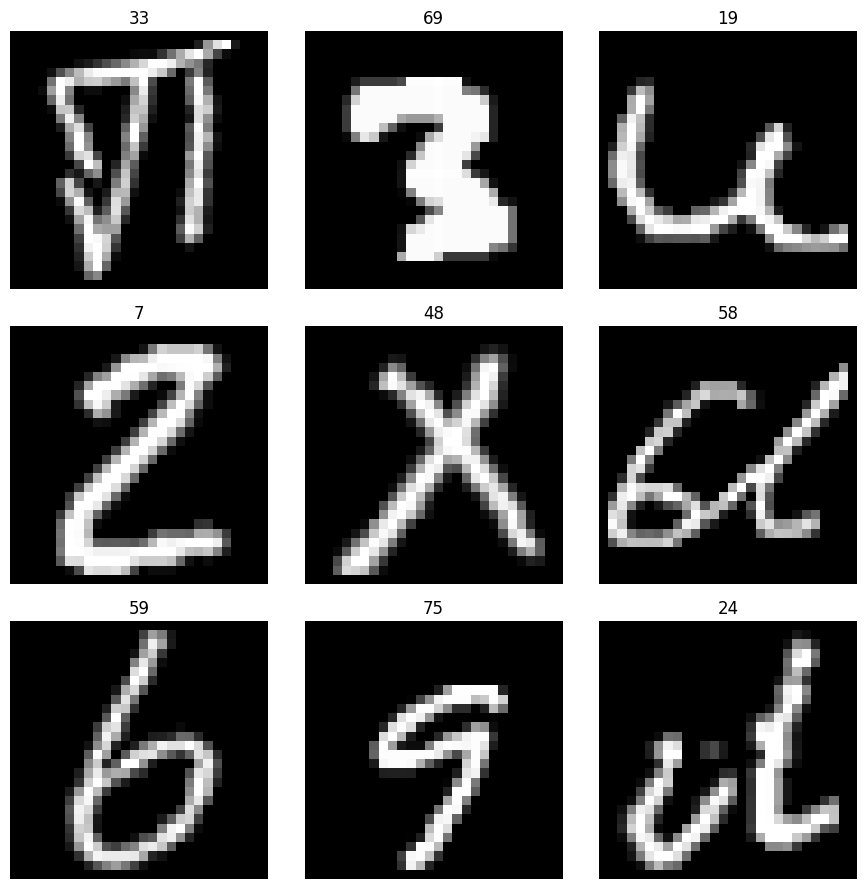

In [4]:
# Визуализация случайных изображений из датасета
fig = plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    num = random.randint(0, len(images) - 1)
    image = images[num].reshape(28, 28)  # Предполагаем размер 28x28
    plt.imshow(image, cmap="gray", interpolation=None)
    plt.title(labels[num])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Преобразуем тип данных в float32 и нормализуем пиксели в диапазон [0,1]
images = images.astype('float32') / 255.0

# Разделим данные на обучающую и тестовую выборки (например, 80% обучающая, 20% тестовая)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (331855, 784)
y_train shape: (331855,)
x_test shape: (82964, 784)
y_test shape: (82964,)


In [6]:
# Кодирование меток
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Определение количества классов
num_classes = len(np.unique(y_train_encoded))
print("Количество классов:", num_classes)

# One-hot encoding
y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes)

Количество классов: 72


In [7]:
# Функция для создания модели с уменьшенным размером
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(224, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(112, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(56, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )
    return model

In [8]:
# Определение формы входных данных
input_shape = (28 * 28,)

# Создание модели
model = create_model(input_shape, num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 224)               175840    
_________________________________________________________________
dropout (Dropout)            (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 112)               25200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 56)                6328      
_________________________________________________________________
dropout_2 (Dropout)          (None, 56)                0

In [9]:
# Callbacks для автоматической остановки и уменьшения скорости обучения
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Обучение модели
history = model.fit(
    x_train,
    y_train_categorical,
    batch_size=128,
    epochs=500,  # Можно оставить 10 эпох
    validation_split=0.3,
    verbose=1,
    callbacks=[reduce_lr, early_stopping]
)


Train on 232298 samples, validate on 99557 samples
Epoch 1/500
232298/232298 [==============================] - 11s 46us/sample - loss: 2.6968 - accuracy: 0.3601 - val_loss: 1.7537 - val_accuracy: 0.5992
Epoch 2/500
232298/232298 [==============================] - 10s 42us/sample - loss: 2.0552 - accuracy: 0.5050 - val_loss: 1.5583 - val_accuracy: 0.6492
Epoch 3/500
232298/232298 [==============================] - 10s 41us/sample - loss: 1.9263 - accuracy: 0.5385 - val_loss: 1.4723 - val_accuracy: 0.6709
Epoch 4/500
232298/232298 [==============================] - 10s 41us/sample - loss: 1.8573 - accuracy: 0.5558 - val_loss: 1.4150 - val_accuracy: 0.6810
Epoch 5/500
232298/232298 [==============================] - 10s 43us/sample - loss: 1.8160 - accuracy: 0.5657 - val_loss: 1.3877 - val_accuracy: 0.6853
Epoch 6/500
232298/232298 [==============================] - 10s 42us/sample - loss: 1.7860 - accuracy: 0.5716 - val_loss: 1.3682 - val_accuracy: 0.6946
Epoch 7/500
232298/232298 [====

Epoch 53/500
232298/232298 [==============================] - 11s 46us/sample - loss: 1.4579 - accuracy: 0.6357 - val_loss: 1.0635 - val_accuracy: 0.7433
Epoch 54/500
232298/232298 [==============================] - 9s 39us/sample - loss: 1.4543 - accuracy: 0.6365 - val_loss: 1.0697 - val_accuracy: 0.7436
Epoch 55/500
232298/232298 [==============================] - 9s 38us/sample - loss: 1.4555 - accuracy: 0.6354 - val_loss: 1.0614 - val_accuracy: 0.7454
Epoch 56/500
232298/232298 [==============================] - 9s 38us/sample - loss: 1.4531 - accuracy: 0.6358 - val_loss: 1.0630 - val_accuracy: 0.7445
Epoch 57/500
232298/232298 [==============================] - 9s 39us/sample - loss: 1.4559 - accuracy: 0.6352 - val_loss: 1.0640 - val_accuracy: 0.7432
Epoch 58/500
232298/232298 [==============================] - 9s 39us/sample - loss: 1.4532 - accuracy: 0.6365 - val_loss: 1.0531 - val_accuracy: 0.7452
Epoch 59/500
232298/232298 [==============================] - 9s 40us/sample - lo

232298/232298 [==============================] - 12s 54us/sample - loss: 1.2818 - accuracy: 0.6686 - val_loss: 0.9330 - val_accuracy: 0.7676
Epoch 105/500
232298/232298 [==============================] - 16s 67us/sample - loss: 1.2802 - accuracy: 0.6703 - val_loss: 0.9338 - val_accuracy: 0.7673
Epoch 106/500
232298/232298 [==============================] - 14s 61us/sample - loss: 1.2762 - accuracy: 0.6710 - val_loss: 0.9340 - val_accuracy: 0.7646
Epoch 107/500
232298/232298 [==============================] - 11s 47us/sample - loss: 1.2771 - accuracy: 0.6705 - val_loss: 0.9349 - val_accuracy: 0.7669
Epoch 108/500
232298/232298 [==============================] - 12s 50us/sample - loss: 1.2767 - accuracy: 0.6701 - val_loss: 0.9322 - val_accuracy: 0.7661
Epoch 109/500
232298/232298 [==============================] - 11s 46us/sample - loss: 1.2720 - accuracy: 0.6713 - val_loss: 0.9295 - val_accuracy: 0.7658
Epoch 110/500
232298/232298 [==============================] - 11s 48us/sample - los

Epoch 155/500
232298/232298 [==============================] - 9s 40us/sample - loss: 1.2236 - accuracy: 0.6814 - val_loss: 0.8972 - val_accuracy: 0.7729
Epoch 156/500
232298/232298 [==============================] - 11s 47us/sample - loss: 1.2205 - accuracy: 0.6826 - val_loss: 0.8990 - val_accuracy: 0.7717
Epoch 157/500
232298/232298 [==============================] - 11s 49us/sample - loss: 1.2252 - accuracy: 0.6812 - val_loss: 0.8981 - val_accuracy: 0.7726
Epoch 158/500
232298/232298 [==============================] - 14s 61us/sample - loss: 1.2217 - accuracy: 0.6822 - val_loss: 0.8983 - val_accuracy: 0.7732
Epoch 159/500
232298/232298 [==============================] - 12s 52us/sample - loss: 1.2237 - accuracy: 0.6808 - val_loss: 0.9001 - val_accuracy: 0.7720
Epoch 160/500
231040/232298 [============================>.] - ETA: 0s - loss: 1.2217 - accuracy: 0.6816
Epoch 00160: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
232298/232298 [=========================

232298/232298 [==============================] - 11s 48us/sample - loss: 1.2081 - accuracy: 0.6852 - val_loss: 0.8912 - val_accuracy: 0.7735
Epoch 204/500
232298/232298 [==============================] - 10s 44us/sample - loss: 1.2066 - accuracy: 0.6850 - val_loss: 0.8909 - val_accuracy: 0.7736
Epoch 205/500
232298/232298 [==============================] - 11s 49us/sample - loss: 1.2050 - accuracy: 0.6860 - val_loss: 0.8908 - val_accuracy: 0.7736
Epoch 206/500
231296/232298 [============================>.] - ETA: 0s - loss: 1.2026 - accuracy: 0.6858
Epoch 00206: ReduceLROnPlateau reducing learning rate to 1e-06.
232298/232298 [==============================] - 11s 45us/sample - loss: 1.2026 - accuracy: 0.6857 - val_loss: 0.8909 - val_accuracy: 0.7739
Epoch 207/500
232298/232298 [==============================] - 11s 48us/sample - loss: 1.2075 - accuracy: 0.6854 - val_loss: 0.8908 - val_accuracy: 0.7738
Epoch 208/500
232298/232298 [==============================] - 10s 42us/sample - los

Epoch 255/500
232298/232298 [==============================] - 12s 53us/sample - loss: 1.2069 - accuracy: 0.6854 - val_loss: 0.8905 - val_accuracy: 0.7737
Epoch 256/500
232298/232298 [==============================] - 10s 45us/sample - loss: 1.2050 - accuracy: 0.6865 - val_loss: 0.8904 - val_accuracy: 0.7737
Epoch 257/500
232298/232298 [==============================] - 11s 49us/sample - loss: 1.2076 - accuracy: 0.6862 - val_loss: 0.8904 - val_accuracy: 0.7737
Epoch 258/500
232298/232298 [==============================] - 11s 46us/sample - loss: 1.2030 - accuracy: 0.6869 - val_loss: 0.8905 - val_accuracy: 0.7736
Epoch 259/500
232298/232298 [==============================] - 14s 61us/sample - loss: 1.2038 - accuracy: 0.6869 - val_loss: 0.8905 - val_accuracy: 0.7738
Epoch 260/500
232298/232298 [==============================] - 11s 49us/sample - loss: 1.2037 - accuracy: 0.6854 - val_loss: 0.8904 - val_accuracy: 0.7737
Epoch 261/500
232298/232298 [==============================] - 10s 44u

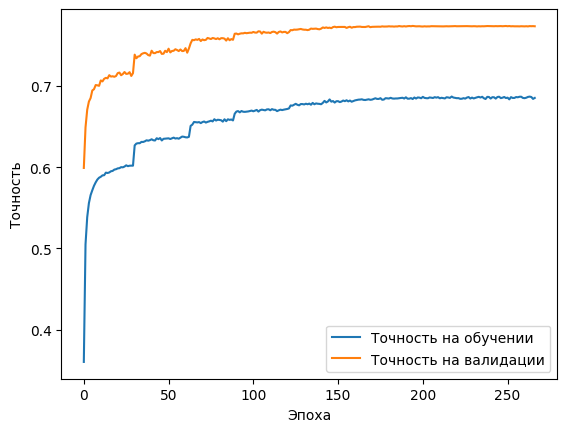

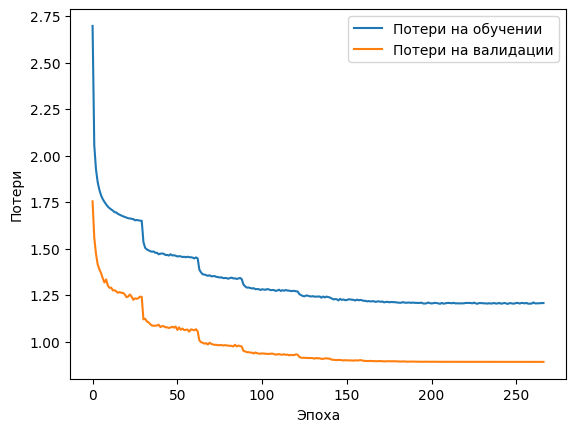

In [10]:
# График точности
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

# График потерь
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.show()

In [11]:
scores = model.evaluate(x_test, y_test_categorical, verbose=2)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

82964/1 - 3s - loss: 0.8226 - accuracy: 0.7767
Test Loss: 0.8838583655254135
Test Accuracy: 0.77669835


In [12]:
model.save("custom_model.h5")

In [13]:
# Конвертация в TFLite модель
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("custom_model.tflite", "wb") as f:
    f.write(tflite_model)

In [14]:
# Ниже код тестирования, который был исходный, без изменений.
interpreter = tf.lite.Interpreter(model_path="custom_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Здесь мы делаем ресайз входного и выходного тензоров под весь тестовый набор сразу
interpreter.resize_tensor_input(input_details[0]['index'], (x_test.shape[0], 28*28))
interpreter.resize_tensor_input(output_details[0]['index'], (x_test.shape[0], num_classes))
interpreter.allocate_tensors()

# Установка тестовых данных
interpreter.set_tensor(input_details[0]['index'], x_test)
interpreter.invoke()

# Получение результатов
output_data = interpreter.get_tensor(output_details[0]['index'])

# Прогнозируемые классы
predictions = np.argmax(output_data, axis=1)
true_labels = np.argmax(y_test_categorical, axis=1)

# Оценка точности
accuracy = np.mean(predictions == true_labels)
print("TFLite Accuracy:", accuracy)

TFLite Accuracy: 0.7766983269851984


In [15]:
# Генерация C-массива
import binascii
def convert_to_c_array(bytes_data) -> str:
    hexstr = binascii.hexlify(bytes_data).decode("UTF-8")
    hexstr = hexstr.upper()
    array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
    array = [array[i:i+10] for i in range(0, len(array), 10)]
    return ",\n  ".join([", ".join(e) for e in array])

tflite_binary = open("custom_model.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
c_file_content = (
    "const unsigned char tf_model[] = {\n  " +
    ascii_bytes +
    "\n};\nunsigned int tf_model_len = " +
    str(len(tflite_binary)) + ";"
)

with open("model.h", "w") as f:
    f.write(c_file_content)